# ANN Classifier
## By Luis Emilio Garduno Garcia

**References:**
- https://www.javatpoint.com/how-to-sort-tuple-in-python
- https://favtutor.com/blogs/remove-duplicates-from-list-python
- https://datascience.stackexchange.com/questions/36049/how-to-adjust-the-hyperparameters-of-mlp-classifier-to-get-more-perfect-performa
- https://stackoverflow.com/questions/73006227/a-question-about-mlp-what-does-this-line-mean
- https://databricks.com/notebooks/churn/4-hyperparameter-tuning.html
- https://python-course.eu/machine-learning/neural-networks-with-scikit.php

## 1. Library import and data loading

In [1]:
import pandas as pd 
import numpy as np 
import itertools
import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler 
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## 2. Get the data

**We may use 'emp_attrition_prepared' file from Clustering_PCA (section 5.3.1), because it contains a pre-processed data frame including the dummies, useful for further analysis.**  

Glimpse of the dataset using head() function displaying only 3 rows

In [2]:
df = pd.read_csv('emp_attrition_prepared.csv')
df.head(3)

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Manager,JobRole_Manufacturing_Director,JobRole_Research_Director,JobRole_Research_Scientist,JobRole_Sales_Executive,JobRole_Sales_Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes,Attrition_Yes
0,41,1102,1,2,2,94,3,2,4,5993,...,0,0,0,0,1,0,0,1,1,1
1,49,279,8,1,3,61,2,2,2,5130,...,0,0,0,1,0,0,1,0,0,0
2,37,1373,2,2,4,92,2,1,3,2090,...,0,0,0,0,0,0,0,1,1,1


In [3]:
df.info() #to confirm the proper dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Age                                1470 non-null   int64
 1   DailyRate                          1470 non-null   int64
 2   DistanceFromHome                   1470 non-null   int64
 3   Education                          1470 non-null   int64
 4   EnvironmentSatisfaction            1470 non-null   int64
 5   HourlyRate                         1470 non-null   int64
 6   JobInvolvement                     1470 non-null   int64
 7   JobLevel                           1470 non-null   int64
 8   JobSatisfaction                    1470 non-null   int64
 9   MonthlyIncome                      1470 non-null   int64
 10  NumCompaniesWorked                 1470 non-null   int64
 11  PercentSalaryHike                  1470 non-null   int64
 12  PerformanceRating   

## 3. Split the data

Before start Machine Learning algorithms, we assign the Attrition_Yes field to a new variable called 'target'.

Moreover, we create another variable called 'features', excluding the Attrition_Yes field.

In [4]:
target = df['Attrition_Yes'] #Dependent variable Y
features = df.drop(['Attrition_Yes'], axis = 1) #Independent variables X

In [5]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

## 4. Implement a pipeline by using a scaler method and MLP Classifier

### 4.1 Define all the possible Hidden Layer combinations for the MLP Classifier

In [6]:
listLayers = [ [2,5,10], [0,2,5,10], [0,2,5,10] ]
hlc = [] #hlc: hidden layer combination

for i in itertools.product(*listLayers):
    hlc.append(i)
#hlc

Assure the amount of neurons in each layer:
    - The number of neurons/perceptrons in the third layer is smaller or equal that the ones on the second layer. 
    - The number of neurons in the second layer must be smaller than or equal to the ones in the first layer
    - And so forth.
To perform this task, we sort the values from highest to lowest

In [7]:
hlc = [sorted(item, reverse=True) for item in hlc]
#hlc

We remove duplicates to keep unique possible hidden layers combinations

In [8]:
result = []
[result.append(x) for x in hlc if x not in result]
result

[[2, 0, 0],
 [2, 2, 0],
 [5, 2, 0],
 [10, 2, 0],
 [2, 2, 2],
 [5, 2, 2],
 [10, 2, 2],
 [5, 5, 2],
 [10, 5, 2],
 [10, 10, 2],
 [5, 0, 0],
 [5, 5, 0],
 [10, 5, 0],
 [5, 5, 5],
 [10, 5, 5],
 [10, 10, 5],
 [10, 0, 0],
 [10, 10, 0],
 [10, 10, 10]]

Zero within a hidden layer means that there is no 2nd, 3rd layer.
To perform this task, we remove number zero from each combination

In [9]:
cleaned = [tuple(n for n in sublist if n != 0) for sublist in result]
#cleaned

We will use each combination (number of neurons by hidden layer) as one of the parameters for MLPClassifier. Thus, we transform the list of tuples to Series

In [10]:
hl_sizes = pd.Series(cleaned, name='sizes') #hl_sizes: hidden layer sizes
hl_sizes

0             (2,)
1           (2, 2)
2           (5, 2)
3          (10, 2)
4        (2, 2, 2)
5        (5, 2, 2)
6       (10, 2, 2)
7        (5, 5, 2)
8       (10, 5, 2)
9      (10, 10, 2)
10            (5,)
11          (5, 5)
12         (10, 5)
13       (5, 5, 5)
14      (10, 5, 5)
15     (10, 10, 5)
16           (10,)
17        (10, 10)
18    (10, 10, 10)
Name: sizes, dtype: object

**We create an empty placeholder list to store the experiments' result.**

In [11]:
score = []

### 4.2 Define the pipeline. 
### We may include GridSearch method to find the best parameter later on

In [13]:
for i in range(len(hl_sizes)): #iterate (i) up to length of previous series where we store each hidden layer combination 
    pipe = Pipeline (
    [('scaler', RobustScaler()),('classifier', MLPClassifier(
                                                learning_rate='adaptive',
                                                max_iter=100,    
                                                hidden_layer_sizes=hl_sizes[i]
                                                            ) 
                                )
    ])
    pipe.fit(X_train, y_train)
    score.append(pipe.score(X_test,y_test)) #append each score to the corresponding empty list
    
    #Set the grid parameters, needed to perform GridSearchCV
    grid_parameters = {
                        'hidden_layer_sizes': [hl_sizes[i]],
                        'learning_rate': ['adaptive'],
                        'max_iter': [100]
    }
    clf = GridSearchCV(MLPClassifier(), grid_parameters, cv=5, scoring='accuracy') #clf: classifier

D:\Programs\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Programs\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Programs\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Programs\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Programs\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptro

## 5. Create a data frame to display results

In [31]:
res_df = pd.DataFrame(zip(hl_sizes,score), columns=['ANN Hidden Layer','Score']) #zip hidden layer sizes from Series 
                                                                                #bullet point 4.1 and score list from pipeline
res_df

,ANN Hidden Layer,Score
0,"(2,)",0.866848
1,"(2, 2)",0.869565
2,"(5, 2)",0.880435
3,"(10, 2)",0.877717
4,"(2, 2, 2)",0.130435
5,"(5, 2, 2)",0.869565
6,"(10, 2, 2)",0.130435
7,"(5, 5, 2)",0.869565
8,"(10, 5, 2)",0.869565
9,"(10, 10, 2)",0.869565


## 6. Select the ANN architecture that gives the best score (validation accuracy) and best parameters

### 6.1 Best method performance

In [32]:
clf.fit(X_train, y_train)
print("Best parameters set found on development set:", clf.best_params_)
print("\nBest method validation accuracy:", clf.best_score_)

D:\Programs\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters set found on development set: {'hidden_layer_sizes': (10, 10, 10), 'learning_rate': 'adaptive', 'max_iter': 100}

Best method validation accuracy: 0.8293994241053065


### 6.2 Get the best estimator

In [33]:
gs_best = clf.best_estimator_ #gs: grid search
gs_best

MLPClassifier(hidden_layer_sizes=(10, 10, 10), learning_rate='adaptive',
              max_iter=100)

## 7. Performance metrics

### 7.1 Classification Report - Precision and Recall

In [34]:
tuned_y_pred = gs_best.predict(X_test) 
print('\n\nTuned Model Stats:')
print(classification_report(y_test, tuned_y_pred, target_names=['class 0', 'class 1']))



Tuned Model Stats:
              precision    recall  f1-score   support

     class 0       0.87      0.97      0.92       320
     class 1       0.20      0.04      0.07        48

    accuracy                           0.85       368
   macro avg       0.54      0.51      0.49       368
weighted avg       0.78      0.85      0.81       368



### 7.2 Confusion Matrix

In [35]:
conf_matrix = confusion_matrix(y_test, tuned_y_pred)
print(conf_matrix)

[[312   8]
 [ 46   2]]


#### 7.2.1 Seaborn heatmap for the confusion matrix

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

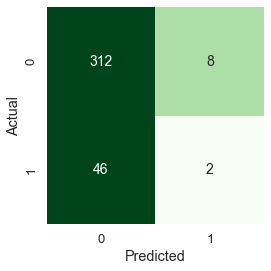

In [36]:
df_cm = pd.DataFrame(conf_matrix, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (4,4))
sns.set(font_scale = 1.2) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 14}, cbar=False, vmax = 20, #vmax from confusion matrix
            square = True, cmap="Greens", fmt='g') #fmt to remove scientific notation